In [1]:
# Import packages
import rasterio
import earthpy.plot as ep
from rasterio.merge import merge
from shapely.geometry import box, mapping
import json

import geopandas as gpd
import pandas as pd
import numpy as np

import keras
from keras import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Flatten, Input, GlobalMaxPooling1D, MaxPooling2D
from keras.callbacks import EarlyStopping
from keras import Model
from keras.utils import to_categorical, plot_model, model_to_dot

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import from_levels_and_colors
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches


import ee
import geemap

import os
from datetime import datetime
import folium

import xarray
from shapely.geometry import JOIN_STYLE, Polygon, MultiPolygon

import json
import pickle

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.inspection import permutation_importance

# CART
from sklearn.tree import DecisionTreeClassifier

# random forest
from sklearn.ensemble import RandomForestClassifier

# xgboost
import xgboost
from xgboost import XGBRegressor, XGBClassifier

c:\Users\juane\miniforge3\envs\satellite_class_3\Lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.3 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [2]:
ee.Initialize()

In [3]:
SEED = 2024
keras.utils.set_random_seed(SEED)
FEATURES = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B9']
LABEL = ['type']

CLASSES = [0, 1, 2, 3, 4, 5]
N_CLASSES = len(CLASSES)

CLASS_VALUES = {
    'urban': 0, 
    'deep_ocean': 1, 
    'shallow_waters': 2, 
    'agriculture': 3,
    'barren': 4,
    'forest': 5
}

class_labels = {v: k for k, v in CLASS_VALUES.items()}

PALETTE = ['#f0027f', '#386cb0', '#ADD8E6', '#fdc086', '#ffff99', '#008080']
NUM_SAMPLES_PER_CLASS = 10_000
# NUM_SAMPLES_PER_CLASS = 100

## Load Data

In [4]:
# Load the Cuba territorial seas shapefile (inside the data folder) using geopandas
cuba_territorial_seas = gpd.read_file(os.path.join('data', 'eez_12nm.zip'))


# The shapefile has only the shape of the territorial seas of Cuba, so we need to fill in the ring to capture
# the whole island.
def close_holes(poly: Polygon) -> Polygon:
        """
        Close polygon holes by limitation to the exterior ring.
        Args:
            poly: Input shapely Polygon
        Example:
            df.geometry.apply(lambda p: close_holes(p))
        """
        if poly.interiors:
            return Polygon(list(poly.exterior.coords))
        else:
            return poly

cuba_territorial_seas = cuba_territorial_seas.geometry.apply(lambda p: close_holes(p))

In [5]:
# Define the image collection and geometry
image_collection = ee.ImageCollection("LANDSAT/LC08/C02/T1_TOA")

# Convert GeoPandas object to Earth Engine geometry
cuba_json = cuba_territorial_seas.to_json()

geometry_cuba = ee.FeatureCollection(json.loads(cuba_json))

## Filter Data

In [6]:
# Define a function to mask clouds for Landsat 8 images
def mask_clouds(image):
    L8cloudShadowBitMask = 1 << 3
    L8cloudsBitMask = 1 << 4
    L8Qa = image.select('QA_PIXEL')
    L8mask = L8Qa.bitwiseAnd(L8cloudShadowBitMask).eq(0) \
             .And(L8Qa.bitwiseAnd(L8cloudsBitMask).eq(0))
    return image.updateMask(L8mask)

In [7]:
geometry_idlj = ee.Geometry.Polygon(
    [[[-83.21494438818296,21.4],
      [-82.5032363193353,21.4],
      [-82.5032363193353,21.93872306614785],
      [-83.21494438818296,21.93872306614785]]])

In [8]:
# Filter the Landsat images
landsat_cuba = image_collection.filterBounds(geometry_cuba).map(mask_clouds)

# Define start and end dates
start_date = ee.Date('2023-01-01')
end_date = ee.Date('2023-12-31')

# Filter by date
landsat_cuba = landsat_cuba.filterDate(start_date, end_date)

# Get median image, only for the geometry of cuba, and for bands with 30m resolution
median_image = landsat_cuba.median().clip(geometry_cuba).select(FEATURES)

# Get median image, only for the geometry of Isla de la Juventud
# We will use this image for visually displaying the model results
median_idlj = landsat_cuba.median().clip(geometry_idlj).select(FEATURES)

# Display the map
mapid = median_image.getMapId({'min': 0, 'max': 0.3, 'bands': ['B4', 'B3', 'B2']})

In [9]:
# Create a Folium map object
map = folium.Map(location=[22, -80], zoom_start=7)

# Add the Landsat image layer
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Google Earth Engine',
    overlay=True,
    name='Landsat Image',
).add_to(map)

# Add layer control
folium.LayerControl().add_to(map)

# Display the map
map

## Create Isla de La Juventud Cutout

We will also save it as a tif file to be able to work with it as a rasterio object.

In [10]:
# Function to split geometry into smaller subregions
def split_geometry(geometry, num_parts):
    bounds = geometry.bounds().getInfo()
    # Extracting bounding coordinates
    xmin = bounds['coordinates'][0][0][0]
    ymin = bounds['coordinates'][0][0][1]
    xmax = bounds['coordinates'][0][2][0]
    ymax = bounds['coordinates'][0][2][1]
    width = (xmax - xmin) / num_parts
    height = (ymax - ymin) / num_parts

    subgeometries = []
    for i in range(num_parts):
        for j in range(num_parts):
            subgeometry = box(xmin + i * width, ymin + j * height,
                              xmin + (i + 1) * width, ymin + (j + 1) * height)
            subgeometries.append(subgeometry)

    return subgeometries

In [11]:
# Create a directory for temporary files if it doesn't exist
temp_dir = "temporary"
if not os.path.exists(temp_dir):
    os.makedirs(temp_dir)

output_path = os.path.join(temp_dir, "ildj_median_2023_merged.tif")
if not os.path.exists(output_path):
    # Split geometry into smaller subregions (to bypass Earth Engine export limit)
    subgeometries = split_geometry(geometry_idlj, num_parts=3)

    # Export and download each subregion
    for i, subgeometry in enumerate(subgeometries):
        output_filename = os.path.join(temp_dir, f"ildj_median_2023_part_{i}.tif")
        # Convert Shapely geometry to GeoJSON
        geojson_geometry = json.dumps(mapping(subgeometry))
        task = geemap.ee_export_image(median_idlj, filename=output_filename, region=geojson_geometry, scale=30)
        print(f"Exporting {output_filename}...")

    # Read and merge downloaded images
    output_files = [os.path.join(temp_dir, f"ildj_median_2023_part_{i}.tif") for i in range(len(subgeometries))]
    datasets = [rasterio.open(file) for file in output_files]
    merged, transform = merge(datasets)

    # Close the datasets
    for dataset in datasets:
        dataset.close()

    # Update the metadata
    profile = datasets[0].profile
    profile.update({"height": merged.shape[1], "width": merged.shape[2], "transform": transform})

    # Output merged image
    with rasterio.open(output_path, "w", **profile) as dst:
        dst.write(merged)

    # Delete smaller TIFF files
    for file in output_files:
        os.remove(file)
else:
    print("Found existing ildj_median_2023_merged.tif file. Using that instead.")

Generating URL ...
Please wait ...
Data downloaded to c:\Users\juane\Desktop\MSc Urban Spatial Science\Term 2\Data Science for Spatial Systems\cuba_landcover_class\temporary\ildj_median_2023_part_0.tif
Exporting temporary\ildj_median_2023_part_0.tif...
Generating URL ...
Please wait ...
Data downloaded to c:\Users\juane\Desktop\MSc Urban Spatial Science\Term 2\Data Science for Spatial Systems\cuba_landcover_class\temporary\ildj_median_2023_part_1.tif
Exporting temporary\ildj_median_2023_part_1.tif...
Generating URL ...
Please wait ...
Data downloaded to c:\Users\juane\Desktop\MSc Urban Spatial Science\Term 2\Data Science for Spatial Systems\cuba_landcover_class\temporary\ildj_median_2023_part_2.tif
Exporting temporary\ildj_median_2023_part_2.tif...
Generating URL ...
Please wait ...
Data downloaded to c:\Users\juane\Desktop\MSc Urban Spatial Science\Term 2\Data Science for Spatial Systems\cuba_landcover_class\temporary\ildj_median_2023_part_3.tif
Exporting temporary\ildj_median_2023_pa

In [13]:
median_image_raster = rasterio.open(output_path)
height = median_image_raster.height
width = median_image_raster.width
shape = (height, width)

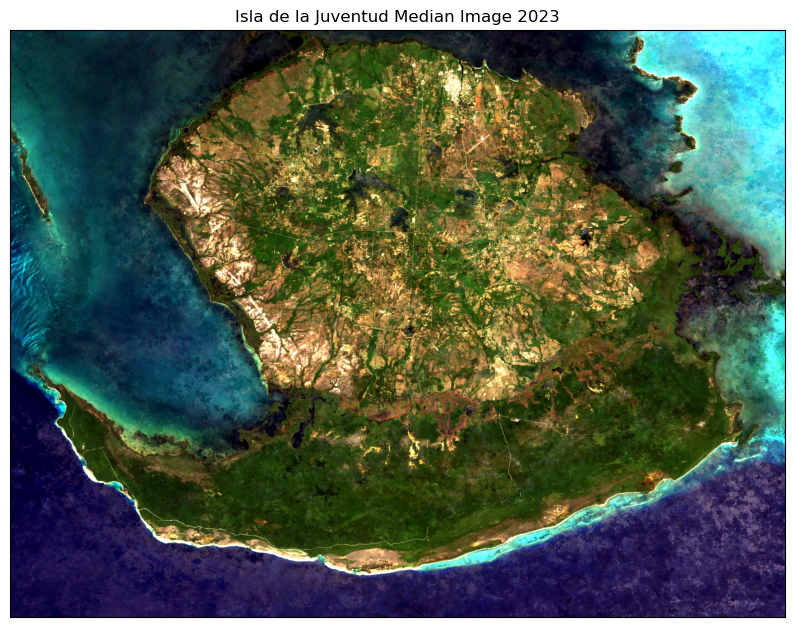

In [64]:
# Plot median_image_raster
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ep.plot_rgb(median_image_raster.read([4, 3, 2]), ax=ax, title="Isla de la Juventud Median Image 2023", stretch=True)
plt.show()

## Set up Samples

In [17]:
# Check if samples file exists
samples_path = os.path.join(temp_dir, "cuba_samples.csv")
if not os.path.exists(samples_path):
    print("Unable to find Cuba samples file. Creating a new one, this may take a while...")

    # Load cuba_samples_polygons.geojson as an Earth Engine FeatureCollection
    cuba_samples = geemap.geojson_to_ee(os.path.join('data', 'cuba_samples_polygons.geojson'))

    # Create an empty list to store the results
    result_list = []

    # Iterate through each 'type' in cuba_samples
    types = cuba_samples.aggregate_array("type").distinct().getInfo()

    for type_value in types:
        print("Sampling: ", type_value)
        # Filter cuba_samples by the current type
        samples_filtered = cuba_samples.filter(ee.Filter.eq("type", type_value))
        
        # Sample the median image at the locations of the filtered samples
        sampled_image = median_image.addBands(ee.Image.constant(CLASS_VALUES[type_value]).rename('int_type')).sample(
            region=samples_filtered.geometry(),
            scale=30,
            numPixels=NUM_SAMPLES_PER_CLASS,  # Specify the number of pixels to sample
            geometries=True,
            seed=SEED
        )
        
        # Add the sampled image to the result list
        result_list.append(sampled_image)

    # Merge all the results into a single ImageCollection
    extract = ee.FeatureCollection(result_list).flatten()

    # -----------------------------------------------------------

    print("Extracting data...")
    # Convert extract to a pandas DataFrame
    samples = geemap.ee_to_df(extract)
    
    # Add column 'int_type' that gives an integer value to each class
    samples['type'] = samples['int_type'].map(class_labels)

    samples = samples.sample(frac = 1, random_state=SEED) # Shuffle data

    # Save the samples to a CSV file in the temporary directory
    samples.to_csv(os.path.join(temp_dir, "cuba_samples.csv"), index=False)

    print("Cuba samples file created successfully.")

else:
    print("Found existing Cuba samples file. Using that instead.")
    samples = pd.read_csv(samples_path)

samples.head()

Found existing Cuba samples file. Using that instead.


,B1,B2,B3,B4,B5,B6,B7,B9,int_type,type
0,0.146778,0.129685,0.124542,0.109618,0.338564,0.267969,0.143241,0.000971,0,urban
1,0.104663,0.080174,0.064804,0.042566,0.236013,0.097950,0.038907,0.001069,5,forest
2,0.105999,0.082121,0.062945,0.040541,0.267835,0.117459,0.045047,0.001414,5,forest
3,0.120281,0.097365,0.083267,0.053222,0.378010,0.165814,0.062410,0.000693,4,barren
4,0.157431,0.137587,0.120909,0.115785,0.204957,0.264614,0.177775,0.000949,4,barren


In [18]:
# Split data into training and testing (75% training, 25% testing)
train = samples.sample(frac=0.75, random_state=SEED)
test = samples.drop(train.index)

# Split between features and label
train_features = train[FEATURES]
train_label = train[['int_type']]
test_features = test[FEATURES]
test_label = test[['int_type']]

# Function to reshape array input
def reshape_input(array):
  shape = array.shape
  return array.reshape(shape[0], shape[1], 1)

# Convert samples dataframe (pandas) to numpy array
train_input = reshape_input(train_features.to_numpy())
test_input = reshape_input(test_features.to_numpy())

# Also make label data to categorical
train_output = to_categorical(train_label.to_numpy(), num_classes=N_CLASSES + 1)
test_output = to_categorical(test_label.to_numpy(), num_classes=N_CLASSES + 1)

# Show the data shape
print(f'Train features: {train_input.shape}\nTest features: {test_input.shape}\nTrain label: {train_output.shape}\nTest label: {test_output.shape}')

Train features: (44208, 8, 1)
Test features: (14736, 8, 1)
Train label: (44208, 7)
Test label: (14736, 7)


## CART Model

We will use GridSearchCV to find the best parameters for our model.

In [19]:
# Modify train and test features to be 2D arrays (for CART and Random Forest)
train_x = train_input.reshape(train_input.shape[0], train_input.shape[1])
train_y = train_output.reshape(train_output.shape[0], train_output.shape[1])

test_x = test_input.reshape(test_input.shape[0], test_input.shape[1])
test_y = test_output.reshape(test_output.shape[0], test_output.shape[1])

In [20]:
# a CART using default settings
cart_default = DecisionTreeClassifier(random_state=SEED)
cart_default.fit(train_x, train_y)
# print the tree depth
print("Tree depth: {}".format(cart_default.get_depth()))

Tree depth: 34


In [21]:
# Create a directory for models files if it doesn't exist
models_dir = "models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

In [22]:
output_path = os.path.join(models_dir, "dt_final.pkl")
if not os.path.exists(output_path):
    
    print("CART model not found. Training a new one...")

    # values of max_depth and min_samples_split
    hyperparameters = {'max_depth':[10,20,30,40,50], 'min_samples_split':[2,4,6,8,10]}

    dt = DecisionTreeClassifier(random_state=SEED)

    # cv=5 by default, which means 5-fold cross-validation
    clf = GridSearchCV(dt, hyperparameters)

    clf.fit(train_x, train_y)

    # we can query the best parameter value and its accuracy score
    print("The best parameter value is: ")
    print(clf.best_params_)
    print("The best score is: ")
    print(clf.best_score_)

    print("Creating and training CART model with best parameters...")

    dt_final = DecisionTreeClassifier(max_depth=clf.best_params_['max_depth'], min_samples_split=clf.best_params_['min_samples_split'], random_state=SEED)
    dt_final.fit(train_x, train_y)

    print("CART model trained successfully. Saving it in models folder...")

    # Save CART model
    with open(output_path, 'wb') as f:
        pickle.dump(dt_final, f)

    print("CART model saved successfully.")

else:
    print("Found existing CART model. Loading it in..")
    # load
    with open(output_path, 'rb') as f:
        dt_final = pickle.load(f)
    
    print("CART model loaded successfully.")

Found existing CART model. Loading it in..
CART model loaded successfully.


In [23]:
print("Classification accuracy on the training data:")
print(dt_final.score(X=train_x, y=train_y))
print("Classification accuracy on the testing data:")
print(dt_final.score(X=test_x, y=test_y))

Classification accuracy on the training data:
0.9909971045964532
Classification accuracy on the testing data:
0.9140200868621065


In [24]:
# some attributes of the tree
print("Tree depth:{}".format(dt_final.get_depth()))
print("Number of leaves:{}".format(dt_final.get_n_leaves()))

Tree depth:20
Number of leaves:1934


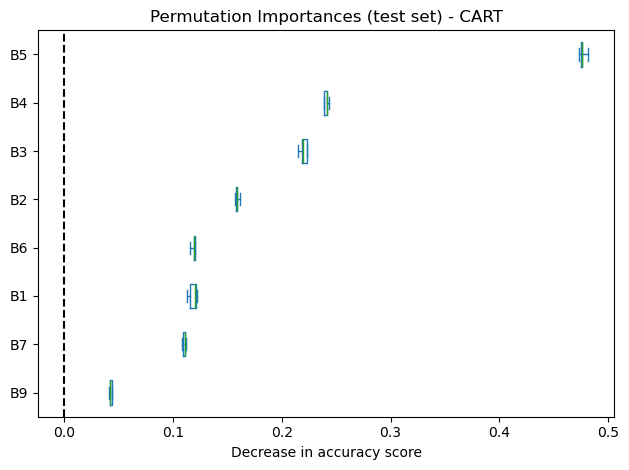

In [25]:
result = permutation_importance(
    dt_final, test_x, test_y, random_state=SEED
)

sorted_importances_idx = result.importances_mean.argsort()


importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=test_features.columns[sorted_importances_idx]
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set) - CART")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

## Random Forest Model

In [26]:
output_path = os.path.join(models_dir, "rf_final.pkl")
if not os.path.exists(output_path):
    
    print("Random Forest model not found. Training a new one...")

    # values of max_depth and min_samples_split
    hyperparameters = {'max_depth':[10,20,30,40,50], 'min_samples_split':[2,4,6,8,10]}

    rf = RandomForestClassifier(random_state=SEED)

    # cv=5 by default, which means 5-fold cross-validation
    clf = GridSearchCV(rf, hyperparameters)

    clf.fit(train_x, train_y)

    # we can query the best parameter value and its accuracy score
    print ("The best parameter value is: ")
    print (clf.best_params_)
    print ("The best score is: ")
    print (clf.best_score_)

    print("Creating and training Random Forest model with best parameters...")

    rf_final = RandomForestClassifier(max_depth=clf.best_params_['max_depth'], min_samples_split=clf.best_params_['min_samples_split'], random_state=SEED)
    rf_final.fit(train_x, train_y)

    print("Random Forest model trained successfully. Saving it in models folder...")

    # Save RF model
    with open(output_path, 'wb') as f:
        pickle.dump(rf_final, f)

    print("Random Forest model saved successfully.")

else:
    print("Found existing Random Forest model. Loading it in..")
    # load
    with open(output_path, 'rb') as f:
        rf_final = pickle.load(f)
    
    print("Random Forest model loaded successfully.")

Found existing Random Forest model. Loading it in..
Random Forest model loaded successfully.


In [27]:
print("Classification accuracy on the training data:")
print(rf_final.score(X=train_x, y=train_y))
print("Classification accuracy on the testing data:")
print(rf_final.score(X=test_x, y=test_y))

Classification accuracy on the training data:
0.9925805284111473
Classification accuracy on the testing data:
0.933699782844734


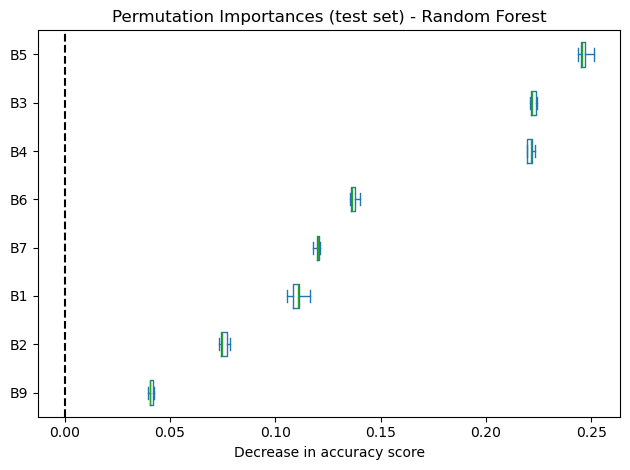

In [28]:
result = permutation_importance(
    rf_final, test_x, test_y, random_state=SEED
)

sorted_importances_idx = result.importances_mean.argsort()


importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=test_features.columns[sorted_importances_idx]
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set) - Random Forest")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

## XGBoost Model

In [29]:
output_path = os.path.join(models_dir, "xgb_final.pkl")
if not os.path.exists(output_path):
    
    print("XGBoost model not found. Training a new one...")

    # values of max_depth and min_samples_split
    hyperparameters = {'max_depth':[10,20,30,40,50], 'n_estimators':[50,100,150,200,250]}

    xgb = XGBClassifier(random_state=SEED)

    # cv=5 by default, which means 5-fold cross-validation
    gscv_xgb = GridSearchCV(xgb, hyperparameters)

    gscv_xgb.fit(train_x, train_y)

    # we can query the best parameter value and its accuracy score
    print ("The best parameter value is: ")
    print (gscv_xgb.best_params_)
    print ("The best score is: ")
    print (gscv_xgb.best_score_)

    print("Creating and training XGBoost model with best parameters...")

    xgb_final = XGBClassifier(max_depth=gscv_xgb.best_params_['max_depth'], n_estimators=gscv_xgb.best_params_['n_estimators'], random_state=SEED)
    xgb_final.fit(train_x, train_y)

    print("XGBoost model trained successfully. Saving it in models folder...")

    # Save XGB model
    with open(output_path, 'wb') as f:
        pickle.dump(xgb_final, f)

    print("XGBoost model saved successfully.")

else:
    print("Found existing XGBoost model. Loading it in..")
    # load
    with open(output_path, 'rb') as f:
        xgb_final = pickle.load(f)
    
    print("XGBoost model loaded successfully.")

Found existing XGBoost model. Loading it in..
XGBoost model loaded successfully.


In [30]:
print("Classification accuracy on the training data:")
print(xgb_final.score(X=train_x, y=train_y))
print("Classification accuracy on the testing data:")
print(xgb_final.score(X=test_x, y=test_y))

Classification accuracy on the training data:
1.0
Classification accuracy on the testing data:
0.9368892508143323


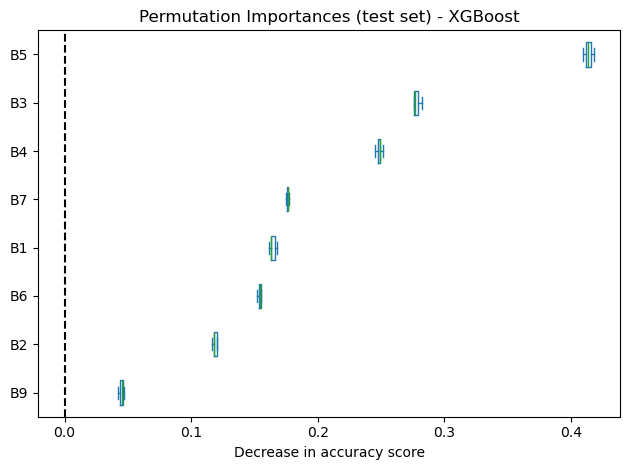

In [31]:
result = permutation_importance(
    xgb_final, test_x, test_y, random_state=SEED
)

sorted_importances_idx = result.importances_mean.argsort()


importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=test_features.columns[sorted_importances_idx]
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set) - XGBoost")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

## Neural Network Model

### Make Model

In [32]:
from keras.layers import Conv1D, Dropout, Dense, Input, Flatten, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [33]:
output_path = os.path.join(models_dir, "nn_final.keras")
if not os.path.exists(output_path):
    
    print("Neural Network model not found. Making a new one...")

    # Make model for our data
    # Input shape
    train_shape = train_input.shape
    input_shape = (train_shape[1], train_shape[2])

    # Model parameter
    neuron = 64
    drop = 0.2
    kernel = 5

    # Make sequential model
    nn_model = Sequential([
        Input(input_shape),
        Conv1D(neuron * 1, kernel, activation='relu', padding='same'),
        Conv1D(neuron * 1, kernel, activation='relu', padding='same'),
        Dropout(drop),
        # BatchNormalization(),  # Added batch normalization layer
        Conv1D(neuron * 2, kernel, activation='relu', padding='same'),
        Conv1D(neuron * 2, kernel, activation='relu', padding='same'),
        Dropout(drop),
        # BatchNormalization(),  # Added batch normalization layer
        # Conv1D(neuron * 4, kernel, activation='relu', padding='same'),
        # Conv1D(neuron * 4, kernel, activation='relu', padding='same'),
        # Dropout(drop),
        # BatchNormalization(),  # Added batch normalization layer
        GlobalMaxPooling1D(),
        Dense(neuron * 4, activation='relu'),
        Dropout(drop),
        Dense(neuron * 2, activation='relu'),
        Dropout(drop),
        Dense(N_CLASSES + 1, activation='softmax')
    ])

    need_to_train_nn = True
    nn_model.summary()


else:
    print("Found existing Neural Network model. Loading it in..")
    # load
    nn_model = keras.models.load_model(output_path)
    need_to_train_nn = False
    print("Neural Network model loaded successfully.")


Found existing Neural Network model. Loading it in..
Neural Network model loaded successfully.


### Train Model

In [34]:
if need_to_train_nn:
    print("Training Neural Network model...")
    
    # Compline the model
    nn_model.compile(
        optimizer='Adam',
        loss='categorical_crossentropy',  # Updated the loss parameter
        metrics=['accuracy']
    )

    # Create callback to stop training if loss not decreasing
    stop = EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
    )

    # reduce_lr = ReduceLROnPlateau(
    #     monitor='val_loss',
    #     factor=0.1,
    #     patience=5,
    #     min_lr=0.0001
    # )

    # Fit the model
    result = nn_model.fit(
        x=train_input, y=train_output,
        validation_data=(test_input, test_output),
        batch_size=1024,
        callbacks=[stop],
        epochs=1000,
    )
    history = pd.DataFrame(result.history)

    # Save the fit results
    with open(os.path.join(models_dir, "nn_fit_history.pkl"), 'wb') as f:
        pickle.dump(history, f)

    # Save the model
    nn_model.save(output_path)
else:
    print("Neural Network model already trained.")
    
    with open(os.path.join(models_dir, "nn_fit_history.pkl"), 'rb') as f:
        history = pickle.load(f)

Neural Network model already trained.


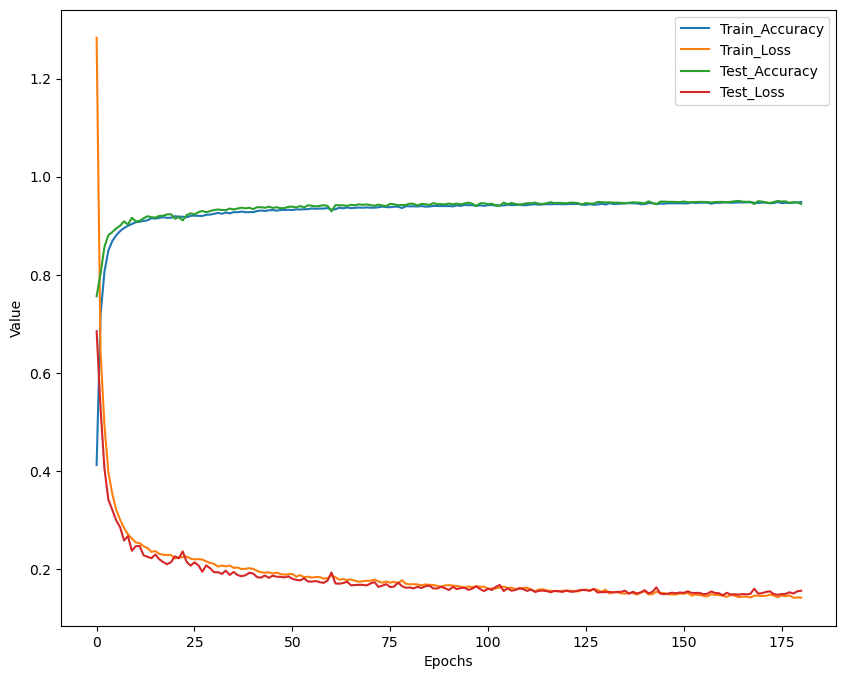

In [35]:
# Show history

plt.figure(figsize = (10, 8))
plt.plot(range(len(history['accuracy'].values.tolist())), history['accuracy'].values.tolist(), label = 'Train_Accuracy')
plt.plot(range(len(history['loss'].values.tolist())), history['loss'].values.tolist(), label = 'Train_Loss')
plt.plot(range(len(history['val_accuracy'].values.tolist())), history['val_accuracy'].values.tolist(), label = 'Test_Accuracy')
plt.plot(range(len(history['val_loss'].values.tolist())), history['val_loss'].values.tolist(), label = 'Test_Loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

In [36]:
# Print the R2 score
nn_model_train_score = nn_model.evaluate(train_input, train_output)
nn_model_test_score = nn_model.evaluate(test_input, test_output)

print("Classification accuracy on the training data:")
print(nn_model_train_score[1])
print("Classification accuracy on the testing data:")
print(nn_model_test_score[1])

1382/1382 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9533 - loss: 0.1298
461/461 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9499 - loss: 0.1421
Classification accuracy on the training data:
0.9533116221427917
Classification accuracy on the testing data:
0.9486970901489258


## Run Models on Isla de La Juventud

In [37]:
src_array = median_image_raster.read()
bands = median_image_raster.count

In [38]:
row_per_pixel = src_array.reshape([bands,-1]).T
columns = [f'band_{n}' for n in range(1,bands+1)]
row_per_pixel_df  = pd.DataFrame(row_per_pixel,columns=columns)

In [62]:
# Check if model predictions pickle file exists
output_path = os.path.join(temp_dir, "model_predictions.pkl")
if not os.path.exists(output_path):
    print("Model predictions file not found. Creating a new one...")

    # CART PREDICTION ---------------------------------------------------
    print("Predicting land cover using CART model...")

    dt_prediction = dt_final.predict(row_per_pixel_df).astype('float64')
    dt_prediction = np.argmax(dt_prediction, 1)
    dt_prediction = dt_prediction.reshape(shape[0], shape[1])

    # RANDOM FOREST PREDICTION --------------------------------------------
    print("Predicting land cover using Random Forest model...")

    rf_prediction = rf_final.predict(row_per_pixel_df).astype('float64')
    rf_prediction = np.argmax(rf_prediction, 1)
    rf_prediction = rf_prediction.reshape(shape[0], shape[1])

    # XGBOOST PREDICTION ---------------------------------------------------
    print("Predicting land cover using XGBoost model...")

    xgb_prediction = xgb_final.predict(row_per_pixel_df).astype('float64')
    xgb_prediction = np.argmax(xgb_prediction, 1)
    xgb_prediction = xgb_prediction.reshape(shape[0], shape[1])

    # NEURAL NETWORK PREDICTION ---------------------------------------------------
    print("Predicting land cover using Neural Network model...")

    # NN Prediction requires slightly different steps due to the model's input shape
    image_input = []
    for x in range(8):
        image_input.append(median_image_raster.read(x + 1))
    image_input = reshape_input(np.stack(image_input).reshape(8, -1).T)

    # Predict
    nn_prediction = nn_model.predict(image_input, batch_size=4096*20)
    nn_prediction = np.argmax(nn_prediction, 1)
    nn_prediction = nn_prediction.reshape(shape[0], shape[1])

    print("Saving results...")
    # Save model predictions
    with open(output_path, 'wb') as f:
        pickle.dump({
            'dt_prediction': dt_prediction,
            'rf_prediction': rf_prediction,
            'xgb_prediction': xgb_prediction,
            'nn_prediction': nn_prediction
        }, f)

    model_predictions = {"Decision Tree": dt_prediction, "Random Forest": rf_prediction, "XGBoost": xgb_prediction, "Neural Network": nn_prediction}

    print("Model predictions file created successfully.")

else:
    print("Found existing model predictions file. Loading it in..")
    # load
    with open(output_path, 'rb') as f:
        model_predictions = pickle.load(f)
    
    dt_prediction = model_predictions['dt_prediction']
    rf_prediction = model_predictions['rf_prediction']
    xgb_prediction = model_predictions['xgb_prediction']
    nn_prediction = model_predictions['nn_prediction']

    
    print("Model predictions loaded successfully.")

Found existing model predictions file. Loading it in..
Model predictions loaded successfully.


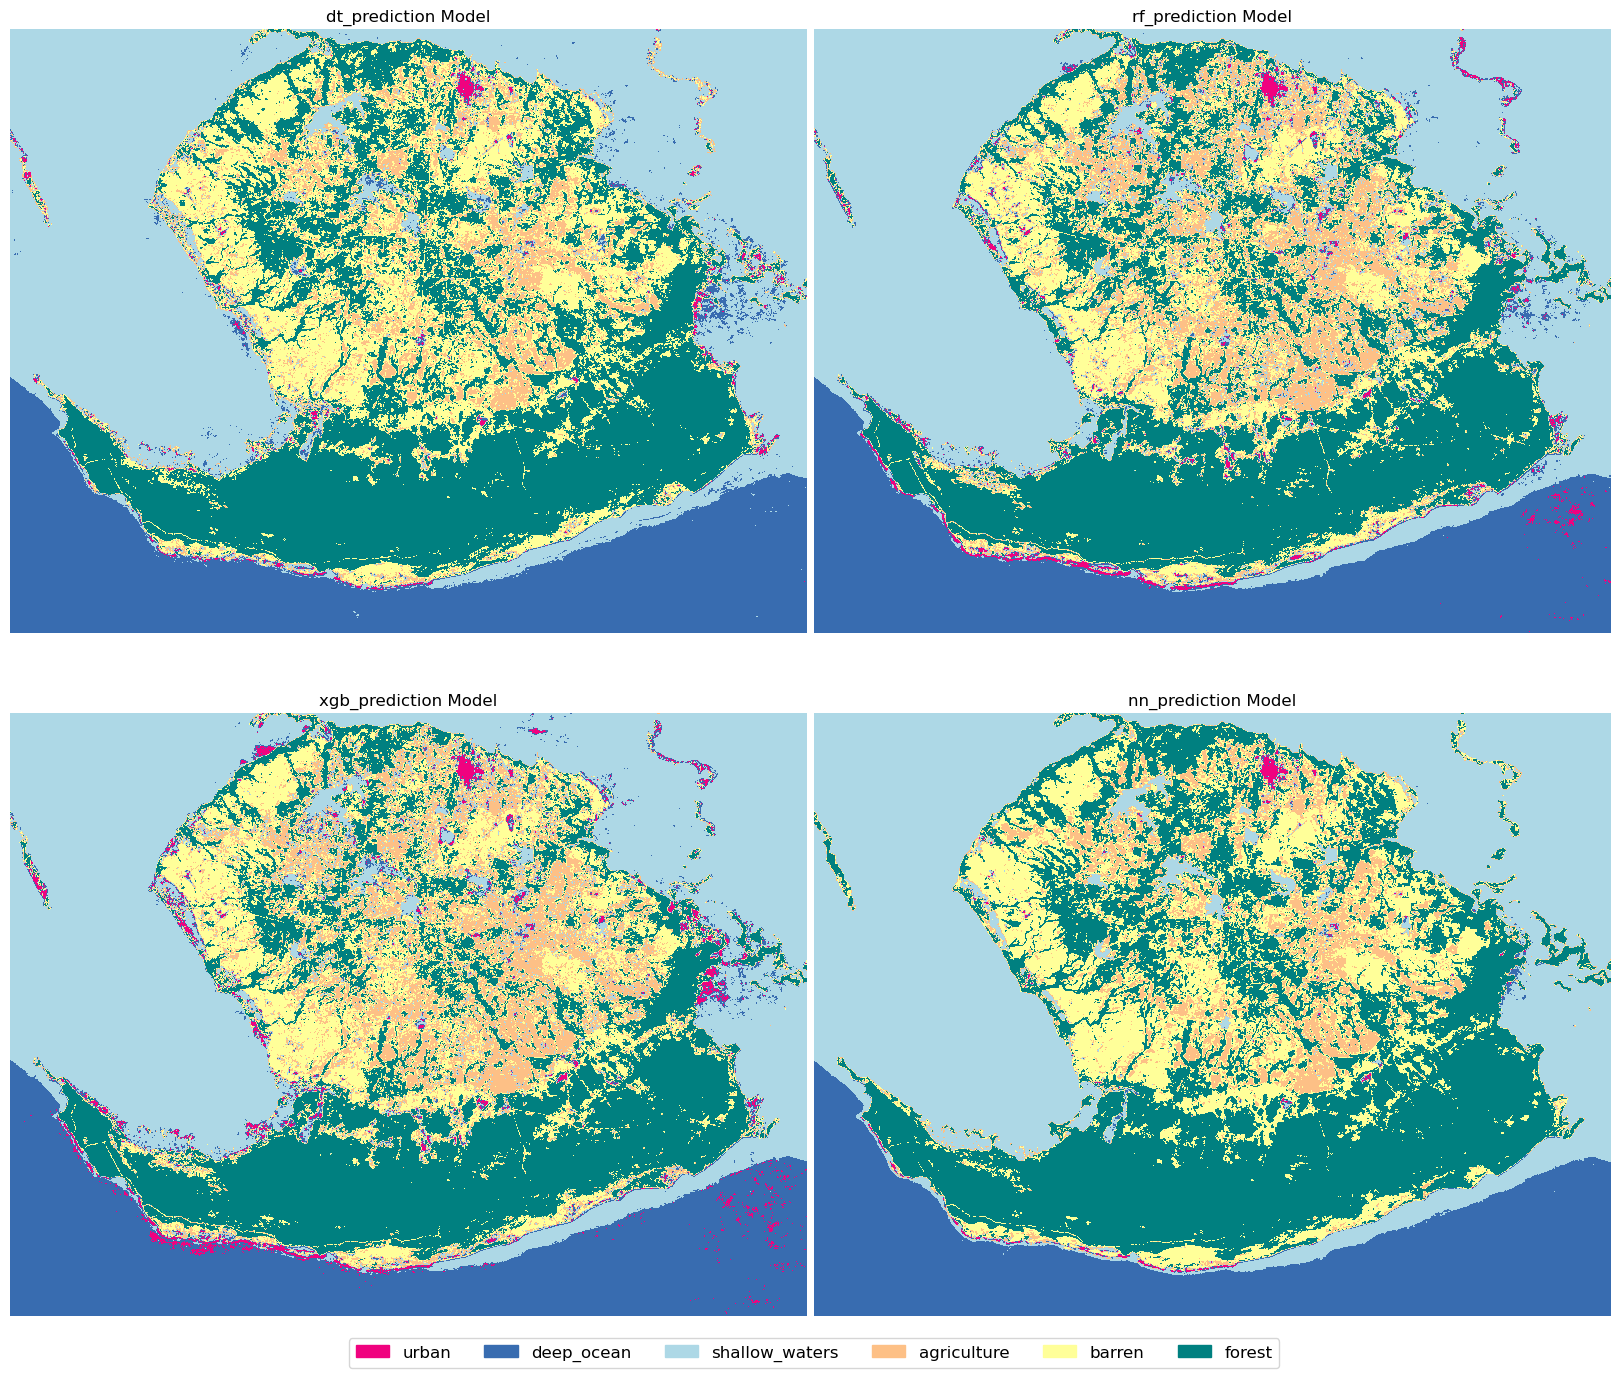

In [63]:
# Create a custom colormap with class labels
colors = [PALETTE[i] for i in CLASSES]
cmap = ListedColormap(colors)

# Plotting the results of each model in separate subplots
num_models = 4
fig, axes = plt.subplots(2, 2, figsize=(16, 16))
for i, (key, value) in enumerate(model_predictions.items()):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    
    # Plot the results of the current model
    ax.imshow(value, cmap=cmap)
    
    # Add title for the subplot
    ax.set_title(f"{key} Model")
    
    # Remove axis
    ax.axis('off')

# Create a custom legend
legend_handles = [mpatches.Patch(color=PALETTE[i], label=class_labels[i]) for i in CLASSES]
plt.legend(handles=legend_handles, loc='lower center', bbox_to_anchor=(0, -0.1), ncol=len(CLASSES), fontsize='12')

plt.subplots_adjust(hspace=0.01, wspace=0.01, bottom=0.15, top=1, left=0, right=1)

plt.show()

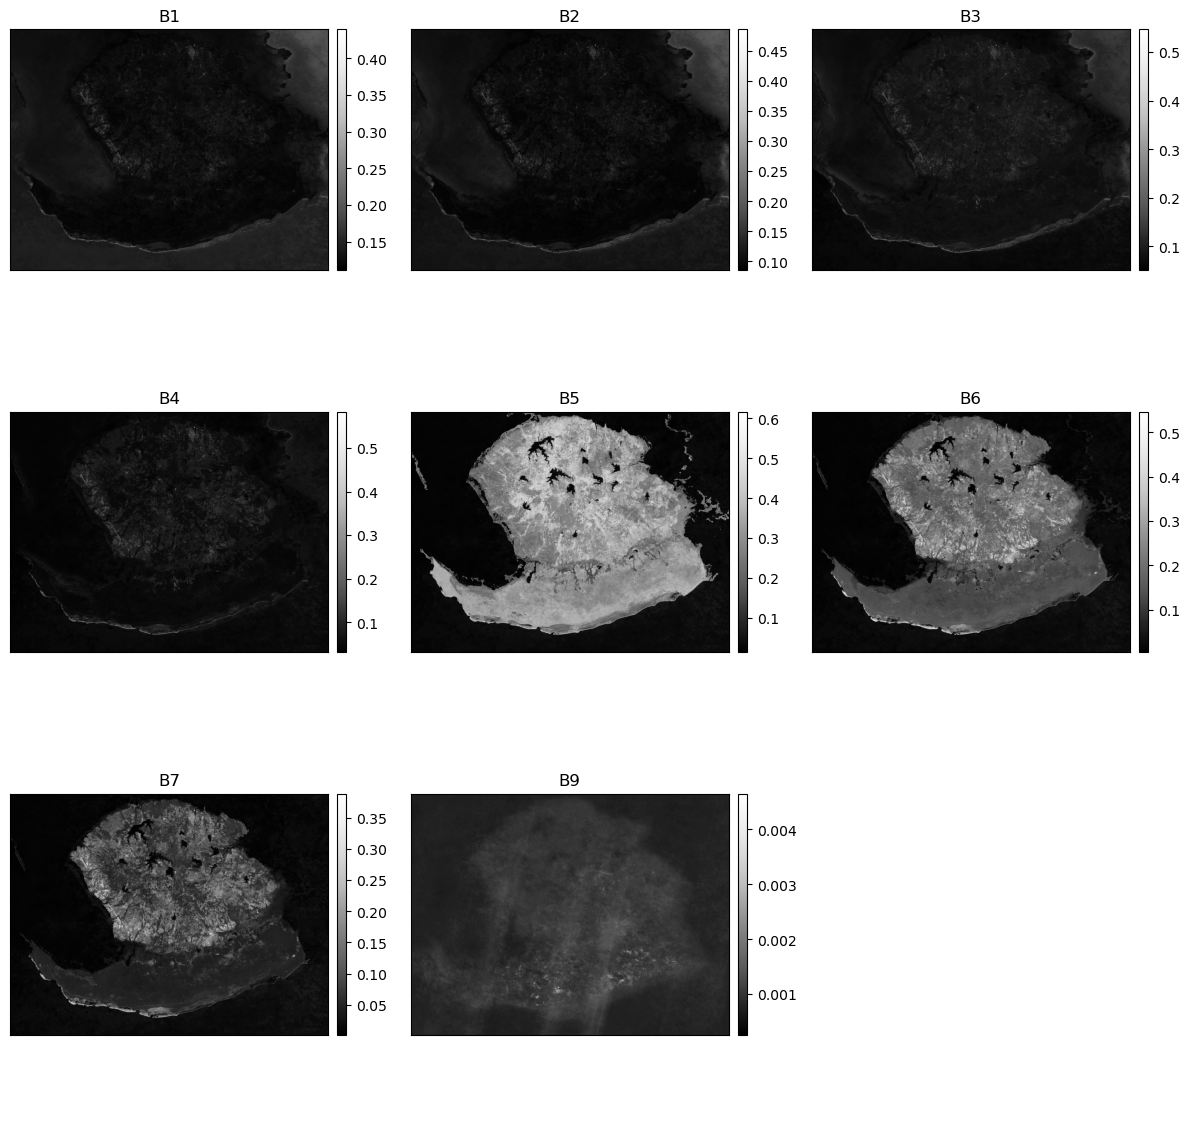

array([[<Axes: title={'center': 'B1'}>, <Axes: title={'center': 'B2'}>,
        <Axes: title={'center': 'B3'}>],
       [<Axes: title={'center': 'B4'}>, <Axes: title={'center': 'B5'}>,
        <Axes: title={'center': 'B6'}>],
       [<Axes: title={'center': 'B7'}>, <Axes: title={'center': 'B9'}>,
        <Axes: >]], dtype=object)

In [44]:
# plot median_image_raster using earthpy
ep.plot_bands(median_image_raster.read(), 
              title=["B1", "B2", "B3", "B4", "B5", "B6", "B7", "B9"],
              cbar=True)

In [45]:
# create a list of models
list_name_models = ['CART', 'RF', 'XGBoost']
# use the models from above
list_reg_models = [dt_final, rf_final, xgb_final]

dict_models = dict()

for name, model in zip(list_name_models, list_reg_models):
    dict_models[name] = [model.score(train_x, train_y), model.score(test_x, test_y), model.score(train_x, train_y) - model.score(test_x, test_y)]

# add the neural network model
dict_models['Neural Network'] = [nn_model_train_score[1], nn_model_test_score[1], nn_model_train_score[1] - nn_model_test_score[1]]

# transform dict_models to dataframe
df_models = pd.DataFrame.from_dict(dict_models, orient='index', columns=['Train Accuracy', 'Test Accuracy', 'Acc. Diff'])
df_models = df_models.sort_values(by='Acc. Diff', ascending=True)

df_models

,Train Accuracy,Test Accuracy,Acc. Diff
Neural Network,0.953312,0.948697,0.004615
RF,0.992581,0.933700,0.058881
XGBoost,1.000000,0.936889,0.063111
CART,0.990997,0.914020,0.076977


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


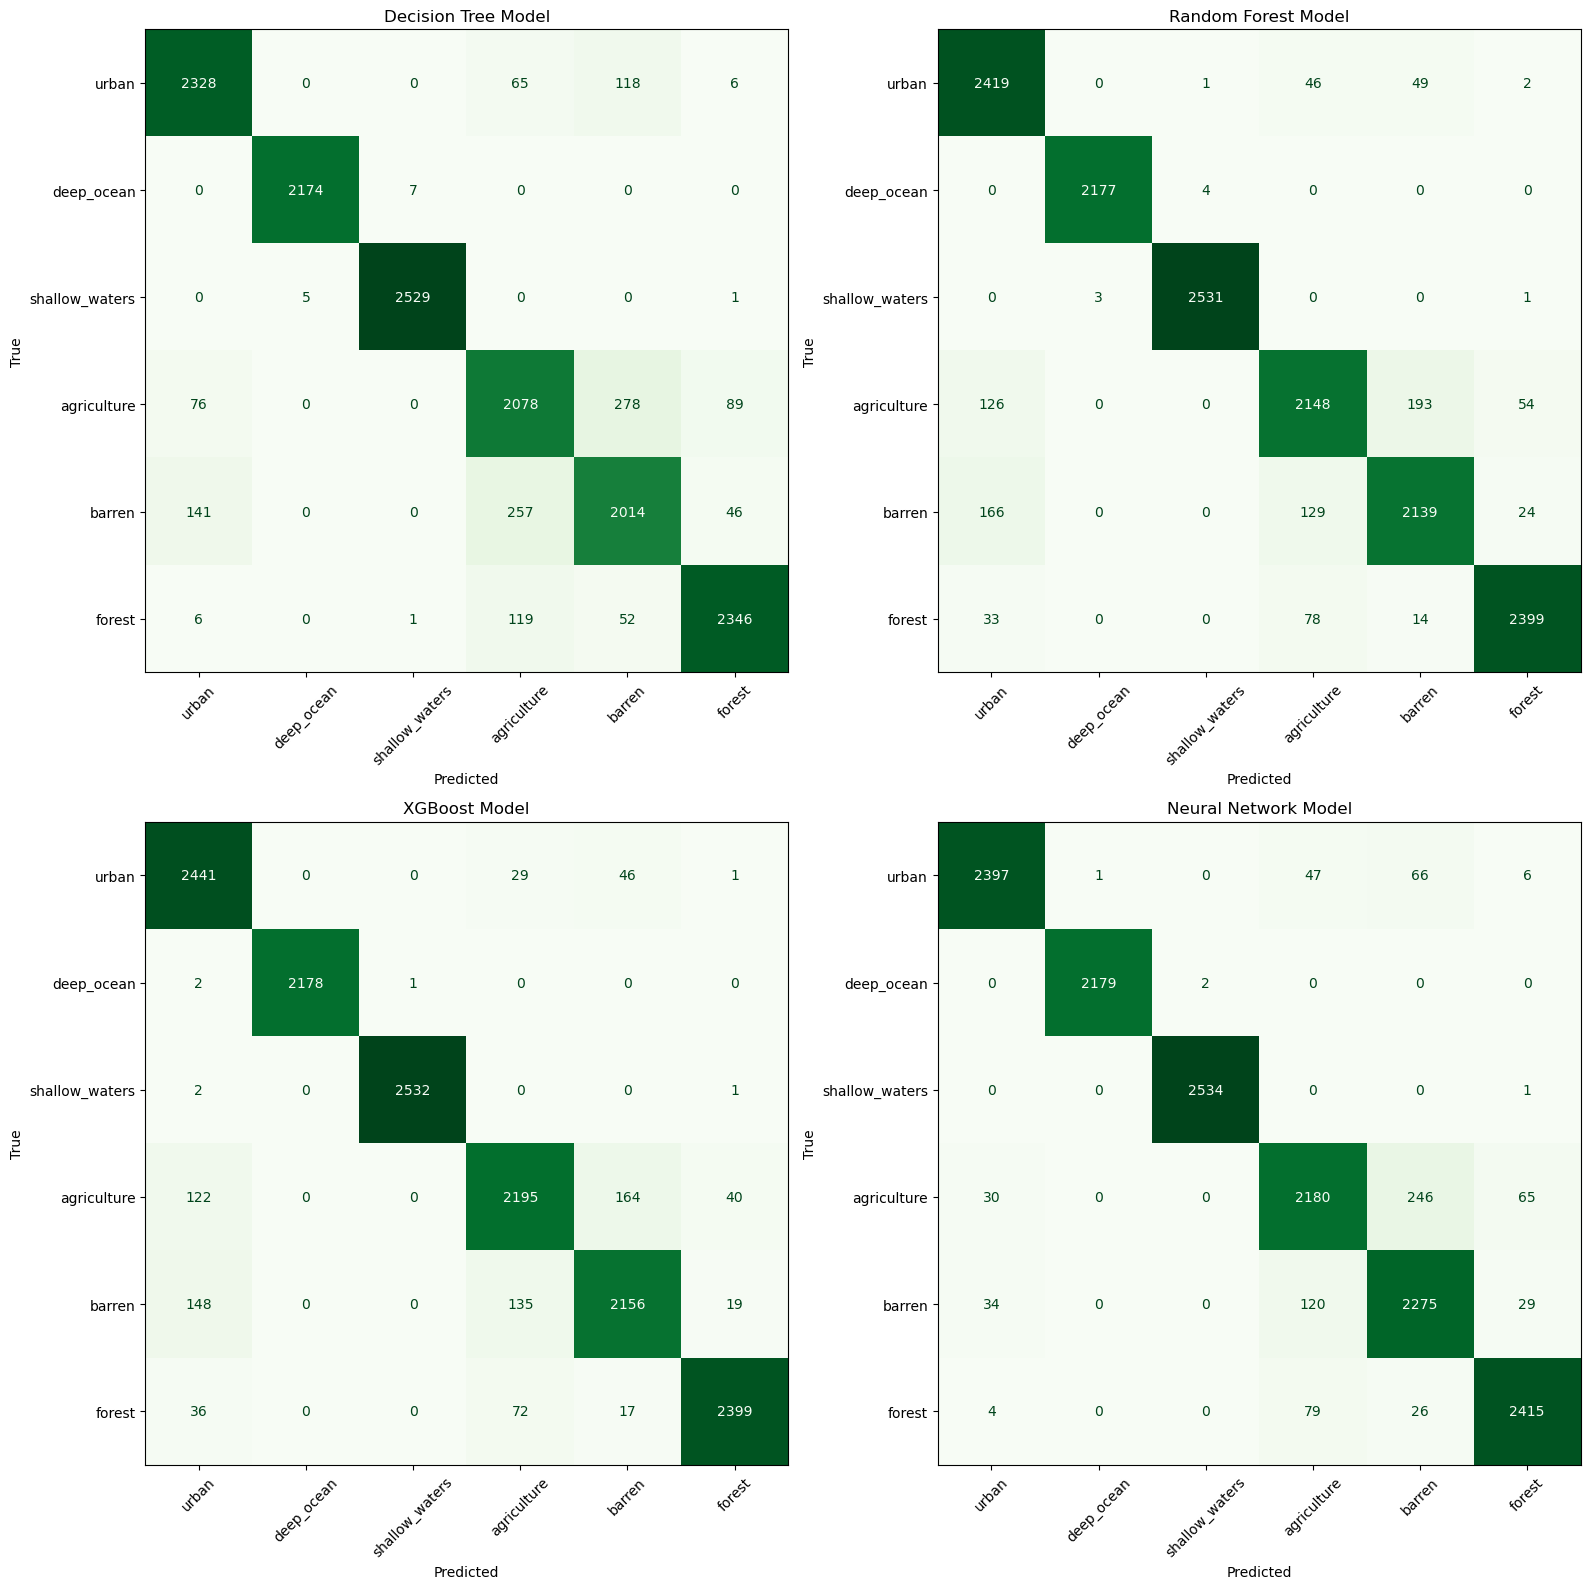

In [46]:
# Plot the confusion matrix for all models
models = {"Decision Tree": dt_final, "Random Forest": rf_final, "XGBoost": xgb_final, "Neural Network": nn_model}

fig, axes = plt.subplots(2, 2, figsize=(16, 16))
for i, (key, value) in enumerate(models.items()):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    
    # Make predictions
    if key == "Neural Network":
        y_pred = value.predict(test_input, batch_size=4096*20)
        y_pred = np.argmax(y_pred, 1)
        y_true = np.argmax(test_output, 1)
    else:
        y_pred = value.predict(test_x)
        y_pred = np.argmax(y_pred, 1)
        y_true = np.argmax(test_y, 1)

    # Plot the confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=range(N_CLASSES))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels.values())
    disp.plot(cmap='Greens', ax=ax)
    ax.set_title(f"{key} Model")
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

    # Hide colorbar
    disp.im_.colorbar.remove()

    # Tilt x-axis labels
    plt.setp(ax.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

In [47]:
# Functions for plotting classification report
# Source: https://stackoverflow.com/questions/28200786/how-to-plot-scikit-learn-classification-report

def show_values(pc, fmt="%.2f", **kw):
    '''
    Heatmap with text in each cell with matplotlib's pyplot
    Source: https://stackoverflow.com/a/25074150/395857 
    By HYRY
    '''
    pc.update_scalarmappable()
    ax = pc.axes
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)


def cm2inch(*tupl):
    '''
    Specify figure size in centimeter in matplotlib
    Source: https://stackoverflow.com/a/22787457/395857
    By gns-ank
    '''
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu', vmin=None, vmax=None):
    '''
    Inspired by:
    - https://stackoverflow.com/a/16124677/395857 
    - https://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
    fig, ax = plt.subplots()    
    #c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap, vmin=vmin, vmax=vmax)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell
    for y in range(AUC.shape[0]):
        for x in range(AUC.shape[1]):
            plt.text(x + 0.5, y + 0.5, '%.2f' % AUC[y, x],
                     horizontalalignment='center',
                     verticalalignment='center',
                     )
    

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()       

    # resize 
    fig = plt.gcf()
    fig.set_size_inches(cm2inch(figure_width, figure_height))



def plot_classification_report(classification_report, title='Classification report ', cmap='RdBu', vmin=None, vmax=None):
    '''
    Plot scikit-learn classification report.
    Extension based on https://stackoverflow.com/a/31689645/395857 
    '''
    lines = classification_report.split('\n')

    classes = []
    plotMat = []
    support = []
    class_names = []

    for line in lines[2 : (len(lines) - 4)]:
        t = line.strip().split()
        if len(t) < 2: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        plotMat.append(v)

    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0}'.format(class_names[idx]) for idx, sup  in enumerate(support)]
    figure_width = 12
    figure_height = len(class_names) + 4
    correct_orientation = False
        
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap, vmin=vmin, vmax=vmax)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step


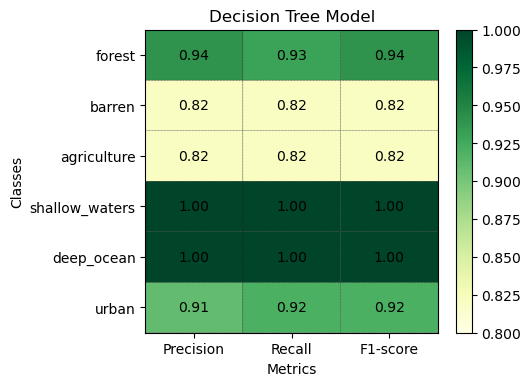

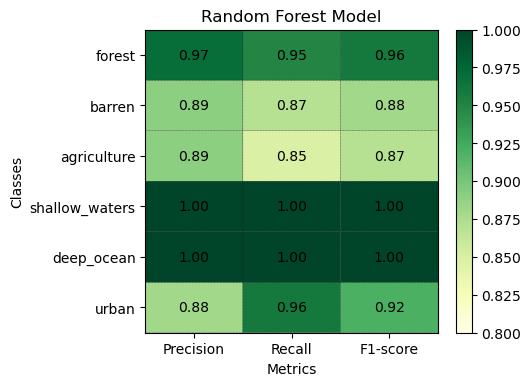

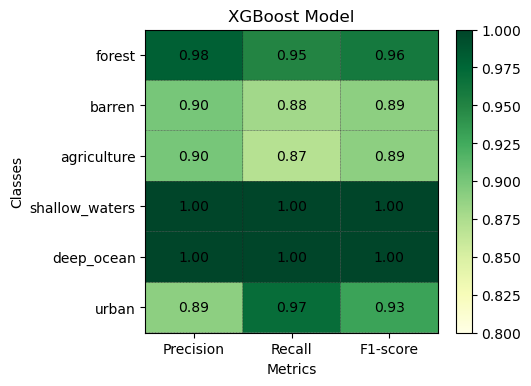

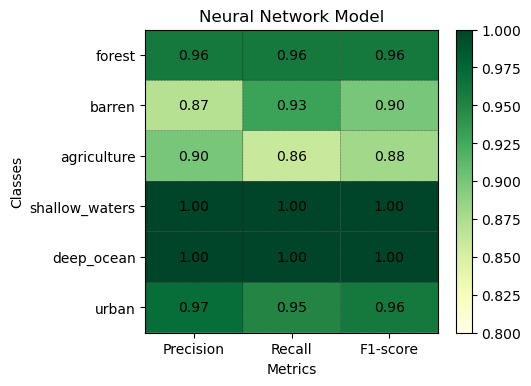

In [48]:
# Plot the classification report for all models
models = {"Decision Tree": dt_final, "Random Forest": rf_final, "XGBoost": xgb_final, "Neural Network": nn_model}

# fig, axes = plt.subplots(2, 2, figsize=(16, 16))
for i, (key, value) in enumerate(models.items()):
    # row = i // 2
    # col = i % 2
    # ax = axes[row, col]
    
    # Make predictions
    if key == "Neural Network":
        y_pred = value.predict(test_input, batch_size=4096*20)
        y_pred = np.argmax(y_pred, 1)
        y_true = np.argmax(test_output, 1)
    else:
        y_pred = value.predict(test_x)
        y_pred = np.argmax(y_pred, 1)
        y_true = np.argmax(test_y, 1)

    # Plot the classification report
    class_report = classification_report(y_true, y_pred, target_names=class_labels.values())
    
    # Plot the classification report
    plot_classification_report(class_report, title=f"{key} Model", cmap='YlGn', vmin=0.8, vmax=1.0)
